In [421]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import math
import tsplib95 as tlib

from networkx.algorithms import community

warnings.simplefilter('ignore')

In [422]:
"""
    Metoda care citeste un graf dintr-un fisier de tip tsp
    @params: filename - path catre un fisier tsp 
    @return: Graph - un obiect de tip Graph
"""
def readGraph(filename):
   return tlib.load(filename).get_graph()

In [423]:
def plotTSP(G, ant, fitnesses, fitness, optim, noIter, node_size = 50, delay = 0.5):
    np.random.seed(42)

    H = nx.Graph()
    H.add_nodes_from(G.nodes)
    
    tour = ant.tour[:]
    tour.append(ant.tour[0])
    for x, y in zip(tour, tour[1:]):
        H.add_edge(x, y, color = 'b')

    pos = nx.spring_layout(H)
    _, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

    nx.draw_networkx_nodes(H, pos, node_size = node_size, cmap = plt.cm.RdYlBu, ax = axis[0])

    edges = H.edges()
    colors = [H[x][y]['color'] for x, y in edges]

    nx.draw_networkx_edges(H, pos, alpha = 0.7, ax = axis[0], edgelist=edges, edge_color=colors)
    nx.draw_networkx_labels(G, pos, ax = axis[0]) # alpha = edge transparancy

    axis[1].set_title("Predicted = " + str(fitness) + " \noptim = " + str(optim))
    axis[1].plot(list(range(noIter)), fitnesses, '-r')

    plt.pause(delay)

In [424]:
class CycleCost:

    def __init__(self, graph):
        self.__graph = graph 

    def __call__(self, ant):
        result = 0
        for node1, node2 in zip(ant.tour, ant.tour[1:]):
            result += self.__graph[node1][node2]['weight']
        
        result += self.__graph[ant.tour[0]][ant.lastNode]["weight"]
        return result

In [425]:
def readSolution(filename):
    lista = []
    with open(filename) as f:
        for _ in range(5):
            f.readline()

        for line in f:
            value = int(line.split()[0])
            if value == -1:
                break
            lista.append(value)
    
    return lista

In [426]:
class Ant:

    def __init__(self, initialNode = None, tour = None):

        if tour != None:
            self.__tour = tour
        else: 
            self.__tour = [initialNode]

    def addNode(self, node):
        self.__tour.append(node)
    
    @property
    def tour(self):
        return self.__tour

    @property
    def lastNode(self):
        return self.__tour[-1]

    @property
    def penultNode(self):
        return self.__tour[-2]

    def possibleNeighbors(self, graph):
        return [x for x in graph.nodes() if x not in self.__tour]

In [427]:
class TSP:

    def __init__(self, params, problParams):
        self.__params = params
        self.__problParams = problParams

        self.__initData(problParams['graph'])

    def __initData(self, graph):

        self.__weights = dict()
        self.__pheromone = dict()

        for node in graph.nodes():
            self.__weights[node] = dict()
            self.__pheromone[node] = dict()

            for ngh in [x for x in graph.neighbors(node) if x > node]:
                self.__weights[node][ngh] = graph[node][ngh]['weight']
                self.__pheromone[node][ngh] = np.random.random() 

        self.__best = None

    def __computeCoefficient(self, node1, node2):
        node1, node2 = min(node1, node2), max(node1, node2) 
        return np.power(self.__pheromone[node1][node2], self.__params['alpha']) * np.power(1 / self.__weights[node1][node2], self.__params['beta'])

    def __computeProbabilities(self, ant):
        possibleNeighbors = ant.possibleNeighbors(self.__problParams['graph'])
        suma = sum([self.__computeCoefficient(ant.lastNode, x) for x in possibleNeighbors])

        return [self.__computeCoefficient(ant.lastNode, node) / suma for node in possibleNeighbors]

    def __moveAnt(self, ant):
        if np.random.random() <= self.__params['q0']:
            maxim = -100
            maximNode = None

            for node in ant.possibleNeighbors(self.__problParams['graph']):
                coefficient = self.__computeCoefficient(ant.lastNode, node)
                if coefficient > maxim:
                    maxim = coefficient
                    maximNode = node

            ant.addNode(maximNode)            
        else:
            ant.addNode(np.random.choice(ant.possibleNeighbors(self.__problParams['graph']), p = self.__computeProbabilities(ant)))
    
    def __updatePheromone(self, node1, node2):
        node1, node2 = min(node1, node2), max(node1, node2) 
        self.__pheromone[node1][node2] = (1 - self.__params['p']) * self.__pheromone[node1][node2] + self.__params['p'] * (1 / self.__weights[node1][node2]) 

    def __moveAntSync(self, ant):
        self.__moveAnt(ant)
        self.__updatePheromone(ant.penultNode, ant.lastNode)
    
    def __bestAnt(self):
        best = self.__ants[0]
        bestCost = self.__problParams['cost'](best)

        for ant in self.__ants[1:]:
           antCost = self.__problParams['cost'](ant) 

           if antCost < bestCost:
               bestCost = antCost
               best = ant
        
        return best

    def __updateAntPheromone(self, ant):
        costUpdate = 1 / self.__problParams['cost'](ant)
        for node1, node2 in zip(ant.tour, ant.tour[1:]):
            node1, node2 = min(node1, node2), max(node1, node2) 
            self.__pheromone[node1][node2] = (1 - self.__params['p']) * self.__pheromone[node1][node2] + self.__params['p'] * costUpdate

        node1, node2 = min(ant.tour[0], ant.lastNode), max(ant.tour[0], ant.lastNode) 
        self.__pheromone[node1][node2] = (1 - self.__params['p']) * self.__pheromone[node1][node2] + self.__params['p'] * costUpdate

    def __updateBestAnt(self):
        best = self.__bestAnt()
        if self.__best == None or self.__problParams['cost'](self.__best) > self.__problParams['cost'](best):
            self.__best = best

    def __syncAllUpdate(self):    
        self.__ants = [Ant(initialNode = np.random.choice(list(self.__problParams['graph'].nodes()))) for _ in range(self.__params['noAnts'])]

        for _ in range(self.__problParams['graph'].number_of_nodes() - 1):
            for ant in self.__ants:
                self.__moveAntSync(ant)
        self.__updateBestAnt()
        #self.__best = self.__bestAnt()
        #self.__updateAntPheromone(self.__best)
    
    def __updateAntsPheromone(self):
        pheromone = dict([[ant, dict([[node, dict([[ngh, 0] for ngh in self.__problParams['graph'].nodes() if ngh > node])] for node in self.__problParams['graph'].nodes()])] for ant in ants])

        for ant in self.__ants:
            cost = self.__problParams['cost'](ant)
            for node1, node2 in zip(ant.tour, ant.tour[1:]):
                node1, node2 = min(node1, node2), max(node1, node2)
                pheromone[ant][node1][node2] = self.__params['Q'] / cost
            pheromone[ant][ant.tour[0]][ant.lastNode] = self.__params['Q'] / cost        

        for node1 in self.__pheromone.keys():
            for node2 in self.__pheromone[node1]:
                self.__pheromone[node1][node2] = (1 - self.__params['p']) * self.__pheromone[node1][node2] + sum([pheromone[ant][node1][node2] for ant in ants])

    def __asyncAllUpdate(self):
        self.__ants = [Ant(initialNode = np.random.choice(list(self.__problParams['graph'].nodes()))) for _ in range(self.__params['noAnts'])]

        for _ in range(self.__problParams['graph'].number_of_nodes() - 1):
            for ant in self.__ants:
                self.__moveAnt(ant)

        self.__updateAntsPheromone()
        self.__updateBestAnt()


    def solve(self):
        fitnesses = []
        for _ in range(self.__params['noIter']):
            self.__syncAllUpdate()
            fitnesses.append(sum([self.__problParams['cost'](ant) for ant in self.__ants]) / self.__params['noAnts'])
            #fitnesses.append(self.__problParams['cost'](self.__best))
        
        return [self.__best, fitnesses]


In [428]:
graphs = [readGraph(os.path.join(os.getcwd(), 'data', 'bays29.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'berlin52.tsp')),
          readGraph(os.path.join(os.getcwd(), 'data', 'ch130.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'ch150.tsp')),
          readGraph(os.path.join(os.getcwd(), 'data', 'eil101.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'gr24.tsp')),
          readGraph(os.path.join(os.getcwd(), 'data', 'gr48.tsp')), readGraph(os.path.join(os.getcwd(), 'data', 'pr76.tsp'))]
opts = [readSolution(os.path.join(os.getcwd(), 'data', 'bays29.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'berlin52.opt.tour')),
          readSolution(os.path.join(os.getcwd(), 'data', 'ch130.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'ch150.opt.tour')),
          readSolution(os.path.join(os.getcwd(), 'data', 'eil101.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'gr24.opt.tour')),
          readSolution(os.path.join(os.getcwd(), 'data', 'gr48.opt.tour')), readSolution(os.path.join(os.getcwd(), 'data', 'pr76.opt.tour'))]

In [429]:
params = {'q0': 0.9, 'alpha': 15, 'beta': 15, 'p': 0.15, 't0': 1, 'noAnts': 32, 'noIter': 512, 'Q': 2} 

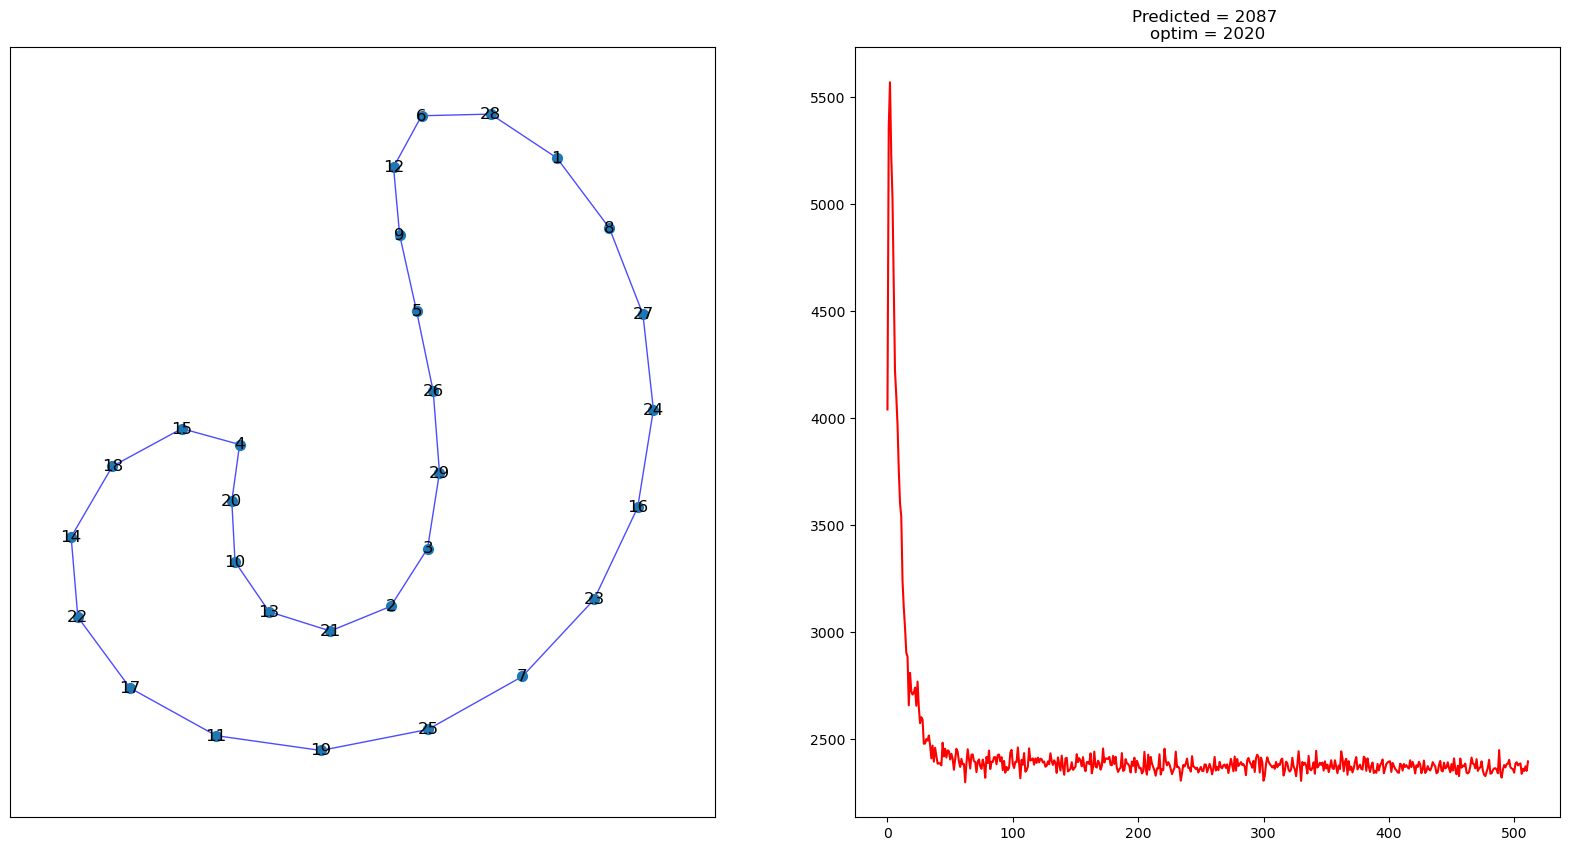

In [430]:
for graph, opt in zip(graphs[:1], opts[:1]):
    problParams = {'graph': graph, 'cost': CycleCost(graph)}
    tsp = TSP(params, problParams)
    [best, fitnesses] = tsp.solve()
    plotTSP(graph, best, fitnesses, problParams['cost'](best), problParams['cost'](Ant(tour = opt)), params['noIter'])